In [1]:
pip install qiskit

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install qiskit-ibm-runtime

   ---------------------------------------- 0.0/3.1 MB ? eta -:--:--
   ---------------------------------------- 3.1/3.1 MB 90.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ---------------------------------------- 1.9/1.9 MB 110.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/570.1 kB ? eta -:--:--
   --------------------------------------- 570.1/570.1 kB 19.2 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.19
    Uninstalling urllib3-1.26.19:
      Successfully uninstalled urllib3-1.26.19
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.27.1
    Uninstalling pydantic_core-2.27.1:
      Successfully uninstalled pydantic_core-2.27.1
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.12
    Uninstalling pydantic-1.10.12:
      Successfully uninstalled pydantic-1.10.12
Note: you may need to restart the kernel to u

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
botocore 1.36.3 requires urllib3<1.27,>=1.25.4; python_version < "3.10", but you have urllib3 2.3.0 which is incompatible.
confection 0.1.0 requires pydantic!=1.8,!=1.8.1,<1.11.0,>=1.7.4, but you have pydantic 2.9.2 which is incompatible.
spacy 3.6.0 requires pydantic!=1.8,!=1.8.1,<1.11.0,>=1.7.4, but you have pydantic 2.9.2 which is incompatible.
thinc 8.1.10 requires pydantic!=1.8,!=1.8.1,<1.11.0,>=1.7.4, but you have pydantic 2.9.2 which is incompatible.


In [4]:
# Import the Qiskit packages
from qiskit import QuantumCircuit, execute, BasicAer
from qiskit.visualization import plot_histogram

# Create a quantum circuit with 2 qubits and 2 classical bits
qc = QuantumCircuit(2, 2)

# Add a Hadamard gate to qubit 0 (puts it in superposition)
qc.h(0)

# Add a CNOT gate with control qubit 0 and target qubit 1 (creates entanglement)
qc.cx(0, 1)

# Measure both qubits
qc.measure([0, 1], [0, 1])

# Draw the circuit
print("Quantum Circuit:")
print(qc.draw())

# Use the BasicAer simulator (compatible with older Qiskit versions)
simulator = BasicAer.get_backend('qasm_simulator')

# Run the circuit on the simulator
job = execute(qc, simulator, shots=1000)

# Get the result
result = job.result()

# Get the counts (measurement outcomes)
counts = result.get_counts()
print("\nMeasurement results:", counts)

# Print a simple interpretation
print("\nHello Quantum World!")
print("This circuit created a Bell state, where qubits 0 and 1 are entangled.")
print("The results show that when we measure, we always see both qubits in the same state:")
print("Either both 0 ('00') or both 1 ('11').")

# Uncomment to show a histogram (requires matplotlib)
# plot_histogram(counts)

ImportError: cannot import name 'execute' from 'qiskit' (c:\Users\Adam\anaconda3\lib\site-packages\qiskit\__init__.py)

In [5]:
pip install --upgrade qiskit

Note: you may need to restart the kernel to use updated packages.


In [6]:
# Import just the essential Qiskit components
from qiskit import QuantumCircuit

# Create a quantum circuit with 2 qubits and 2 classical bits
qc = QuantumCircuit(2, 2)

# Add a Hadamard gate to qubit 0 (puts it in superposition)
qc.h(0)

# Add a CNOT gate with control qubit 0 and target qubit 1 (creates entanglement)
qc.cx(0, 1)

# Measure both qubits
qc.measure([0, 1], [0, 1])

# Draw the circuit
print("Quantum Circuit:")
print(qc.draw())

Quantum Circuit:
     ┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c: 2/═══════════╩══╩═
                0  1 


In [ ]:
# Create a 1-qubit circuit
qc = QuantumCircuit(1, 1)

# Apply a Hadamard gate (creates superposition)
qc.h(0)

# Measure the qubit
qc.measure(0, 0)

# Draw the circuit
print(qc.draw())
print("Hello Quantum World!")

     ┌───┐┌─┐
  q: ┤ H ├┤M├
     └───┘└╥┘
c: 1/══════╩═
           0 
Hello Quantum World!


In [8]:
from qiskit import Aer, execute

ImportError: cannot import name 'Aer' from 'qiskit' (c:\Users\Adam\anaconda3\lib\site-packages\qiskit\__init__.py)

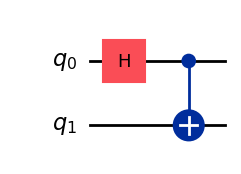

In [ ]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# Create a new circuit with two qubits
qc = QuantumCircuit(2)

# Add a Hadamard gate to qubit 0
qc.h(0)

# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)

# Return a drawing of the circuit using MatPlotLib ("mpl"). This is the
# last line of the cell, so the drawing appears in the cell output.
# Remove the "mpl" argument to get a text drawing.
qc.draw("mpl")

In [10]:
pip install pylatexenc

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136895 sha256=07a1f1e5b423dafb1ff069da321ea893d28060250b5d118680dcc441c56d87f2
  Stored in directory: c:\users\adam\appdata\local\pip\cache\wheels\a3\68\66\2f15abd0673d83c02f354115feedeb89c3daed2ac319b11090
Successfully built pylatexenc
Note: you may need to restart the kernel to use updated packages.
